In [224]:
import numpy as np
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, skeletonize, square, rectangle, disk
from PIL import Image
from scipy import ndimage as ndi
from scipy.ndimage import convolve
from matplotlib import pyplot as plt

from skimage.filters import threshold_otsu
from skimage.filters import sato

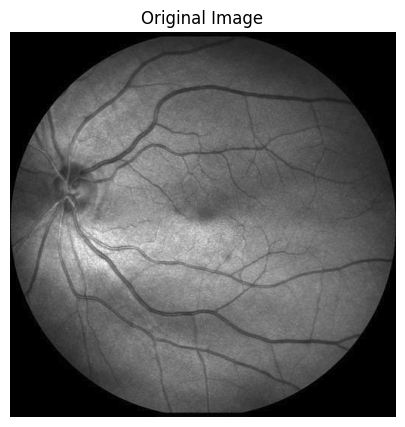

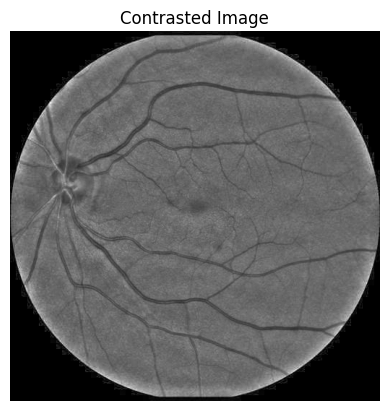

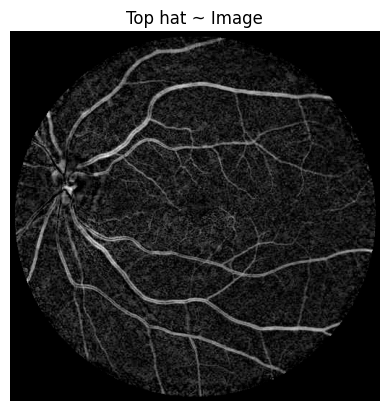

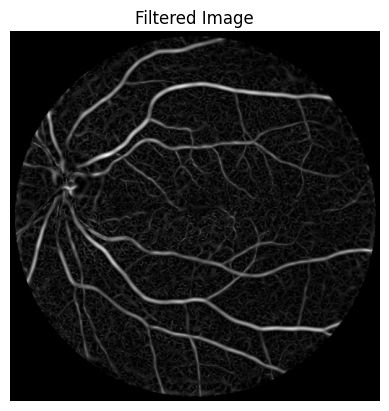

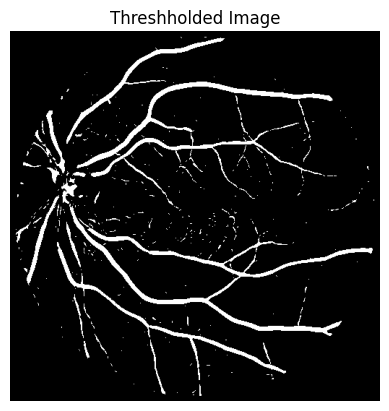

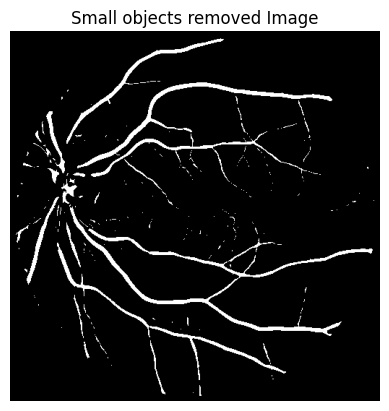

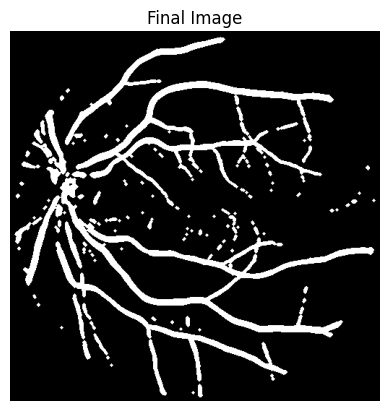

Accuracy = 0.9092673459485686 , Recall = 0.7544283413848631


In [235]:
def my_segmentation(img, img_mask, closing_value = 3, dilation_value = 2, erosion_value=2, kernel_size = 41, tophat = 11, if_print=False, dilation_shape="disk", closing_shape="hor_rect", erosion_shape="vert_rect"):
    
    # -------------------------------
    # ORIGINAL IMAGE
    if(if_print):
        plt.figure(figsize=(10, 5))
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        plt.show()
    # -------------------------------

    # -------------------------------
    # INCREASE IMAGE CONTRAST
    contrasted_img = img
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size) # kernel for filtering
    backgound_mode = convolve(img, kernel) # low pass filter
    contrasted_img = np.divide(img, backgound_mode + 1) - backgound_mode.max() + 128 # apply transformation
    contrasted_img = 255 - np.absolute(contrasted_img) / np.max(np.absolute(contrasted_img)) * 255 # convert image into uint8

    if(if_print):
        plt.imshow(contrasted_img, cmap='gray')
        plt.title('Contrasted Image')
        plt.axis('off')
        plt.show()
    # -------------------------------  
    
    # -------------------------------
    # TOPHAT FILTER
    size = (tophat,tophat) # select closing kernel size
    ferme = ndi.grey_closing(contrasted_img, size=size)

    tophat_ = ferme - contrasted_img # apply filter
    tophat_ = np.multiply(tophat_, img_mask.astype(np.uint8)) # ensure the image fits the mask

    if(if_print):
        plt.imshow(tophat_, cmap='gray')
        plt.title('Top hat ~ Image')
        plt.axis('off')
        plt.show()
    # -------------------------------

    # -------------------------------
    # SATO FILTER IMAGE
    img_filtered = tophat_
    img_filtered = sato(img_filtered, black_ridges=False, sigmas = [1,2,3,4])
    img_filtered = np.multiply(img_filtered, img_mask.astype(np.uint8))

    if(if_print):
        plt.imshow(img_filtered, cmap='gray')
        plt.title('Filtered Image')
        plt.axis('off')
        plt.show()
    # -------------------------------

    # -------------------------------
    # THRESHOLD IMAGE
    thresh = threshold_otsu(img_filtered)
    threshhold_image = img_filtered > thresh

    if(if_print):
        plt.imshow(threshhold_image, cmap='gray')
        plt.title('Threshholded Image')
        plt.axis('off')
        plt.show()
    # -------------------------------

    # -------------------------------
    # REMOVE SMALL OBJECTS
    if(erosion_shape == "vert_rect"):
        threshhold_image = binary_erosion(threshhold_image, rectangle(erosion_value, 1))
    elif(erosion_shape == "hor_rect"):
        threshhold_image = binary_erosion(threshhold_image, rectangle(1, erosion_value))
    elif(erosion_shape == "square"):
        threshhold_image = binary_erosion(threshhold_image, square(erosion_value))
    elif(erosion_shape == "disk"):
        threshhold_image = binary_erosion(threshhold_image, disk(erosion_value))

    if(if_print):
        plt.imshow(threshhold_image, cmap='gray')
        plt.title('Small objects removed Image')
        plt.axis('off')
        plt.show()
    # -------------------------------

    binary = threshhold_image

    if(dilation_shape == "vert_rect"):
        binary = binary_dilation(binary, rectangle(dilation_value, 1))
    elif(dilation_shape == "hor_rect"):
        binary = binary_dilation(binary, rectangle(1, dilation_value))
    elif(dilation_shape == "square"):
        binary = binary_dilation(binary, square(dilation_value))
    elif(dilation_shape == "disk"):
        binary = binary_dilation(binary, disk(dilation_value))


    if(closing_shape == "vert_rect"):
        binary = binary_closing(binary, rectangle(closing_value, 1))
    elif(closing_shape == "hor_rect"):
        binary = binary_closing(binary, rectangle(1, closing_value))
    elif(closing_shape == "square"):
        binary = binary_closing(binary, square(closing_value))
    elif(closing_shape == "disk"):
        binary = binary_closing(binary, disk(closing_value))

    if(if_print):
        plt.imshow(binary, cmap='gray')
        plt.title('Final Image')
        plt.axis('off')
        plt.show()
    
    return binary

def evaluate(img_out, img_GT):
    GT_skel = skeletonize(img_GT) # On reduit le support de l'evaluation...
    img_out_skel = skeletonize(img_out) # ...aux pixels des squelettes
    TP = np.sum(img_out_skel & img_GT) # Vrais positifs
    FP = np.sum(img_out_skel & ~img_GT) # Faux positifs
    FN = np.sum(GT_skel & ~img_out) # Faux negatifs

    ACCU = TP / (TP + FP) # Precision
    RECALL = TP / (TP + FN) # Rappel
    return ACCU, RECALL, img_out_skel, GT_skel

img_code = '01'
optimal_kernel_size = 41
optimal_tophat_size = 11

# open original image in grayscale, read as an ndarray with values between 0 and 256
img =  np.asarray(Image.open('./images_IOSTAR/star' + img_code + '_OSC.jpg')).astype(np.uint8)

# create image mask, which delimits the eye in the figure
nrows, ncols = img.shape
row, col = np.ogrid[:nrows, :ncols]
# we consider only the pixels inside the circle
img_mask = (np.ones(img.shape)).astype(np.bool_)
invalid_pixels = ((row - nrows/2)**2 + (col - ncols/2)**2 > ((0.975 * nrows / 2)**2))
img_mask[invalid_pixels] = 0

# we also take into account the empty rows of pixels in the top and bottom of the image
nb_lines = 6
for i in range(ncols):
    for j in range(nb_lines):
        img_mask[j][i] = 0
        img_mask[nrows - j - 1][i] = 0

img_out = my_segmentation(img, img_mask, if_print=True)
img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_' + img_code + '.png')).astype(np.bool_)

ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
print('Accuracy =', ACCU,', Recall =', RECALL)

# Parameters finetuning 

## Contrast

K =  11 , Accuracy = 0.8717720391807658 , Recall = 0.7786836349174786
K =  21 , Accuracy = 0.908678102926337 , Recall = 0.729740680713128
K =  31 , Accuracy = 0.9036261864200535 , Recall = 0.750252576278036
K =  41 , Accuracy = 0.9092673459485686 , Recall = 0.7544283413848631
K =  51 , Accuracy = 0.9011516314779271 , Recall = 0.7543683470576421
K =  61 , Accuracy = 0.9013346043851287 , Recall = 0.7576121794871795
K =  71 , Accuracy = 0.9043815056886952 , Recall = 0.7514078841512469
K =  81 , Accuracy = 0.9029383429672447 , Recall = 0.7546296296296297


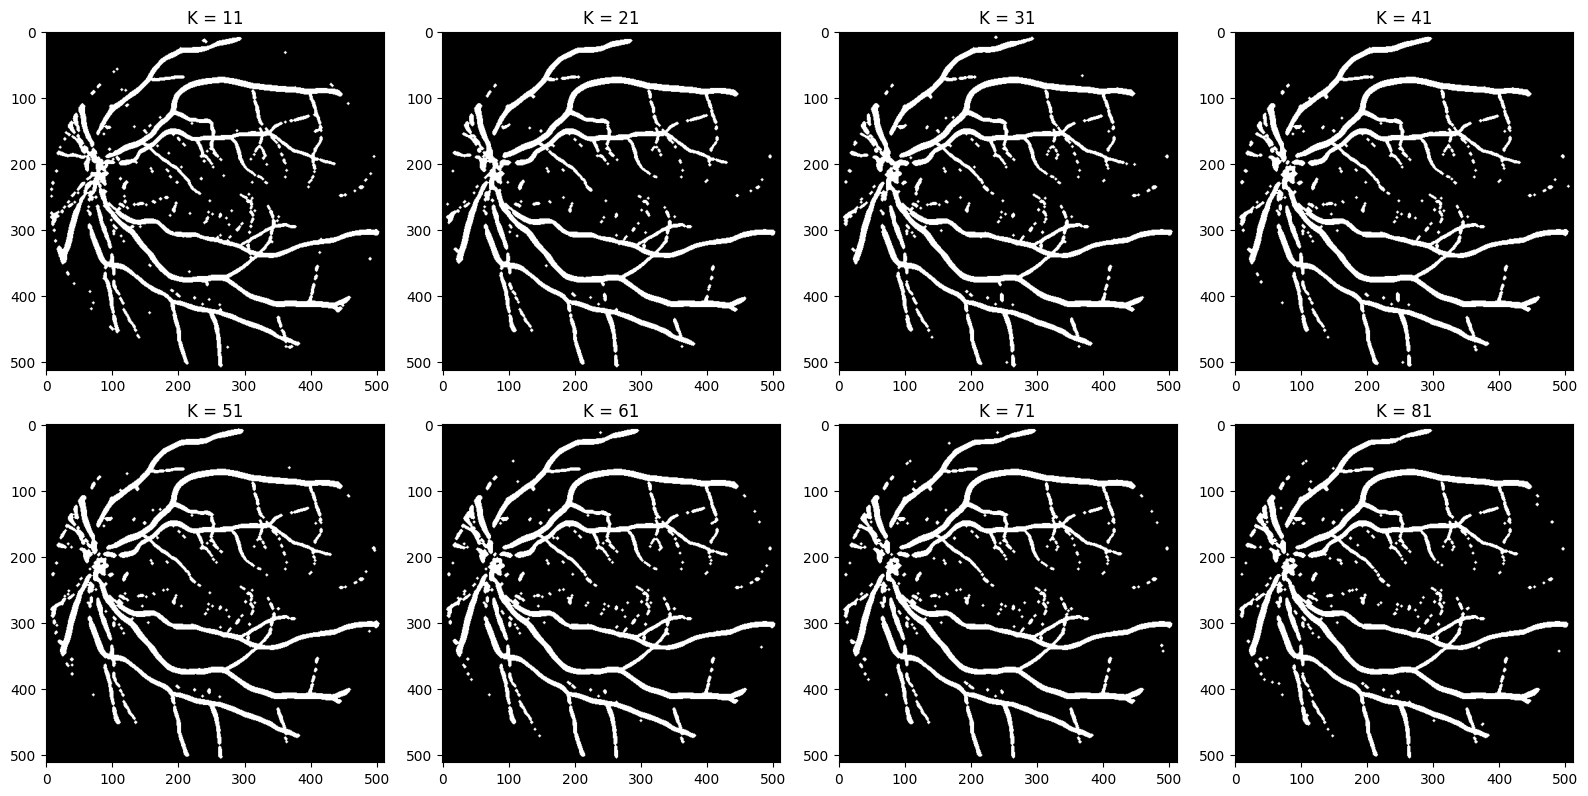

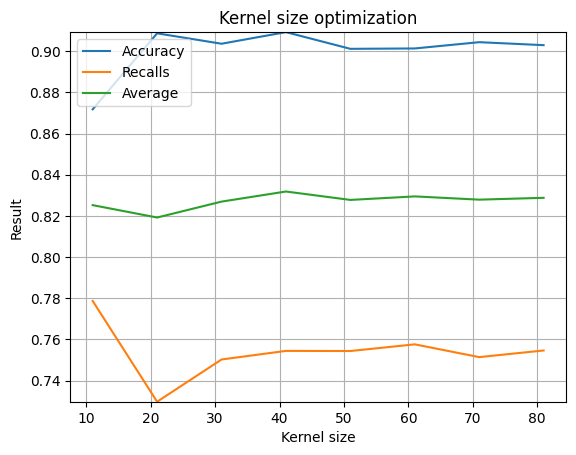

In [236]:
plt.figure(figsize=(16, 8))

test_kernel_sizes = [11, 21, 31, 41, 51, 61, 71, 81]
accuracies = np.zeros((len(test_kernel_sizes),1))
recalls = np.zeros((len(test_kernel_sizes),1))

i = 1
for kernel_size in test_kernel_sizes:
    img_out = my_segmentation(img, img_mask, kernel_size=kernel_size)
    img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

    ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
    print('K = ', kernel_size, ', Accuracy =', ACCU,', Recall =', RECALL)
    accuracies[i - 1] = ACCU
    recalls[i - 1] = RECALL

    plt.subplot(2, 4, i)
    plt.imshow(img_out,cmap = 'gray')
    plt.title('K = ' + str(kernel_size))
    i = i + 1

plt.tight_layout()
plt.show()

plt.plot(test_kernel_sizes, accuracies, label='Accuracy')
plt.plot(test_kernel_sizes, recalls, label='Recalls')
plt.plot(test_kernel_sizes, (accuracies + recalls) / 2, label='Average')

plt.ylim(min([np.min(accuracies), np.min(recalls)]), max([np.max(accuracies), np.max(recalls)]))

# Add labels and title
plt.xlabel('Kernel size')
plt.ylabel('Result')
plt.title('Kernel size optimization')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

## Tophat

K =  7 , Accuracy = 0.856655290102389 , Recall = 0.800957319505385
K =  9 , Accuracy = 0.8999288593787053 , Recall = 0.7609785442149589
K =  11 , Accuracy = 0.9092673459485686 , Recall = 0.7544283413848631
K =  13 , Accuracy = 0.9075980392156863 , Recall = 0.7495951417004049
K =  15 , Accuracy = 0.8902754885801742 , Recall = 0.7627597337099051
K =  17 , Accuracy = 0.8840272876970124 , Recall = 0.7618082302858301
K =  19 , Accuracy = 0.8775842044134727 , Recall = 0.7632323232323233
K =  21 , Accuracy = 0.8727187646233037 , Recall = 0.755213605993116


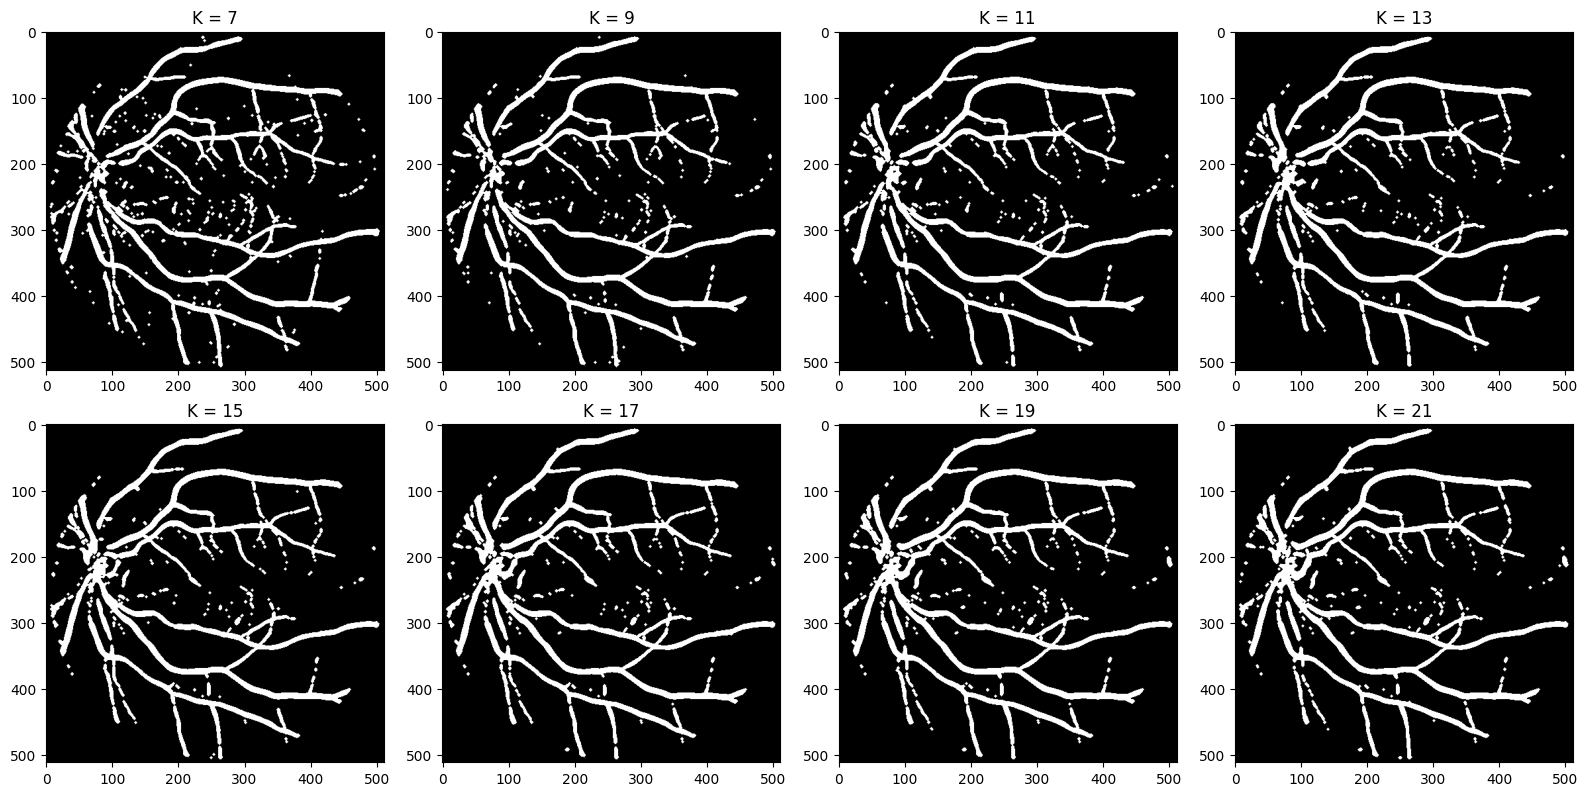

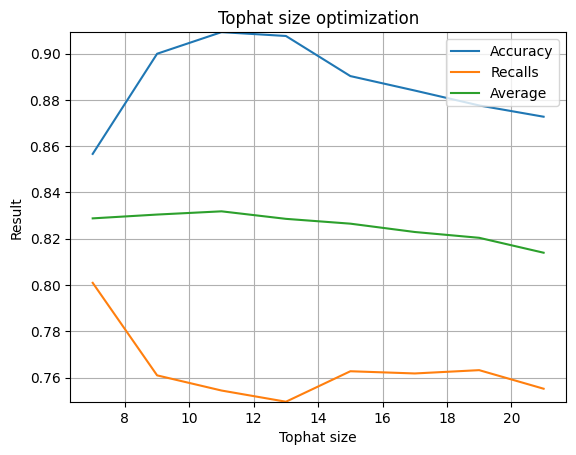

In [237]:
plt.figure(figsize=(16, 8))

test_tophat_sizes = [7, 9, 11, 13, 15, 17, 19, 21]
accuracies = np.zeros((len(test_tophat_sizes),1))
recalls = np.zeros((len(test_tophat_sizes),1))

i = 1
for tophat_size in test_tophat_sizes:
    img_out = my_segmentation(img, img_mask, tophat=tophat_size)
    img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

    ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
    print('K = ', tophat_size, ', Accuracy =', ACCU,', Recall =', RECALL)
    accuracies[i - 1] = ACCU
    recalls[i - 1] = RECALL

    plt.subplot(2, 4, i)
    plt.imshow(img_out,cmap = 'gray')
    plt.title('K = ' + str(tophat_size))
    i = i + 1

plt.tight_layout()
plt.show()

plt.plot(test_tophat_sizes, accuracies, label='Accuracy')
plt.plot(test_tophat_sizes, recalls, label='Recalls')
plt.plot(test_tophat_sizes, (accuracies + recalls) / 2, label='Average')

plt.ylim(min([np.min(accuracies), np.min(recalls)]), max([np.max(accuracies), np.max(recalls)]))

# Add labels and title
plt.xlabel('Tophat size')
plt.ylabel('Result')
plt.title('Tophat size optimization')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

## Erosion

K =  1 , Shape = vert_rect , Accuracy = 0.8124509033778476 , Recall = 0.8250897487036298 , Average =  0.8187703260407387
K =  2 , Shape = vert_rect , Accuracy = 0.9092673459485686 , Recall = 0.7544283413848631 , Average =  0.8318478436667158
K =  3 , Shape = vert_rect , Accuracy = 0.9357266936884772 , Recall = 0.6594572536217098 , Average =  0.7975919736550935
K =  1 , Shape = hor_rect , Accuracy = 0.8124509033778476 , Recall = 0.8250897487036298 , Average =  0.8187703260407387
K =  2 , Shape = hor_rect , Accuracy = 0.8952668680765358 , Recall = 0.7264555669050051 , Average =  0.8108612174907704
K =  3 , Shape = hor_rect , Accuracy = 0.9319096255029403 , Recall = 0.6134881825590872 , Average =  0.7726989040310137
K =  1 , Shape = square , Accuracy = 0.8124509033778476 , Recall = 0.8250897487036298 , Average =  0.8187703260407387
K =  2 , Shape = square , Accuracy = 0.9439031591378801 , Recall = 0.6470350131552317 , Average =  0.7954690861465559
K =  3 , Shape = square , Accuracy = 0.95

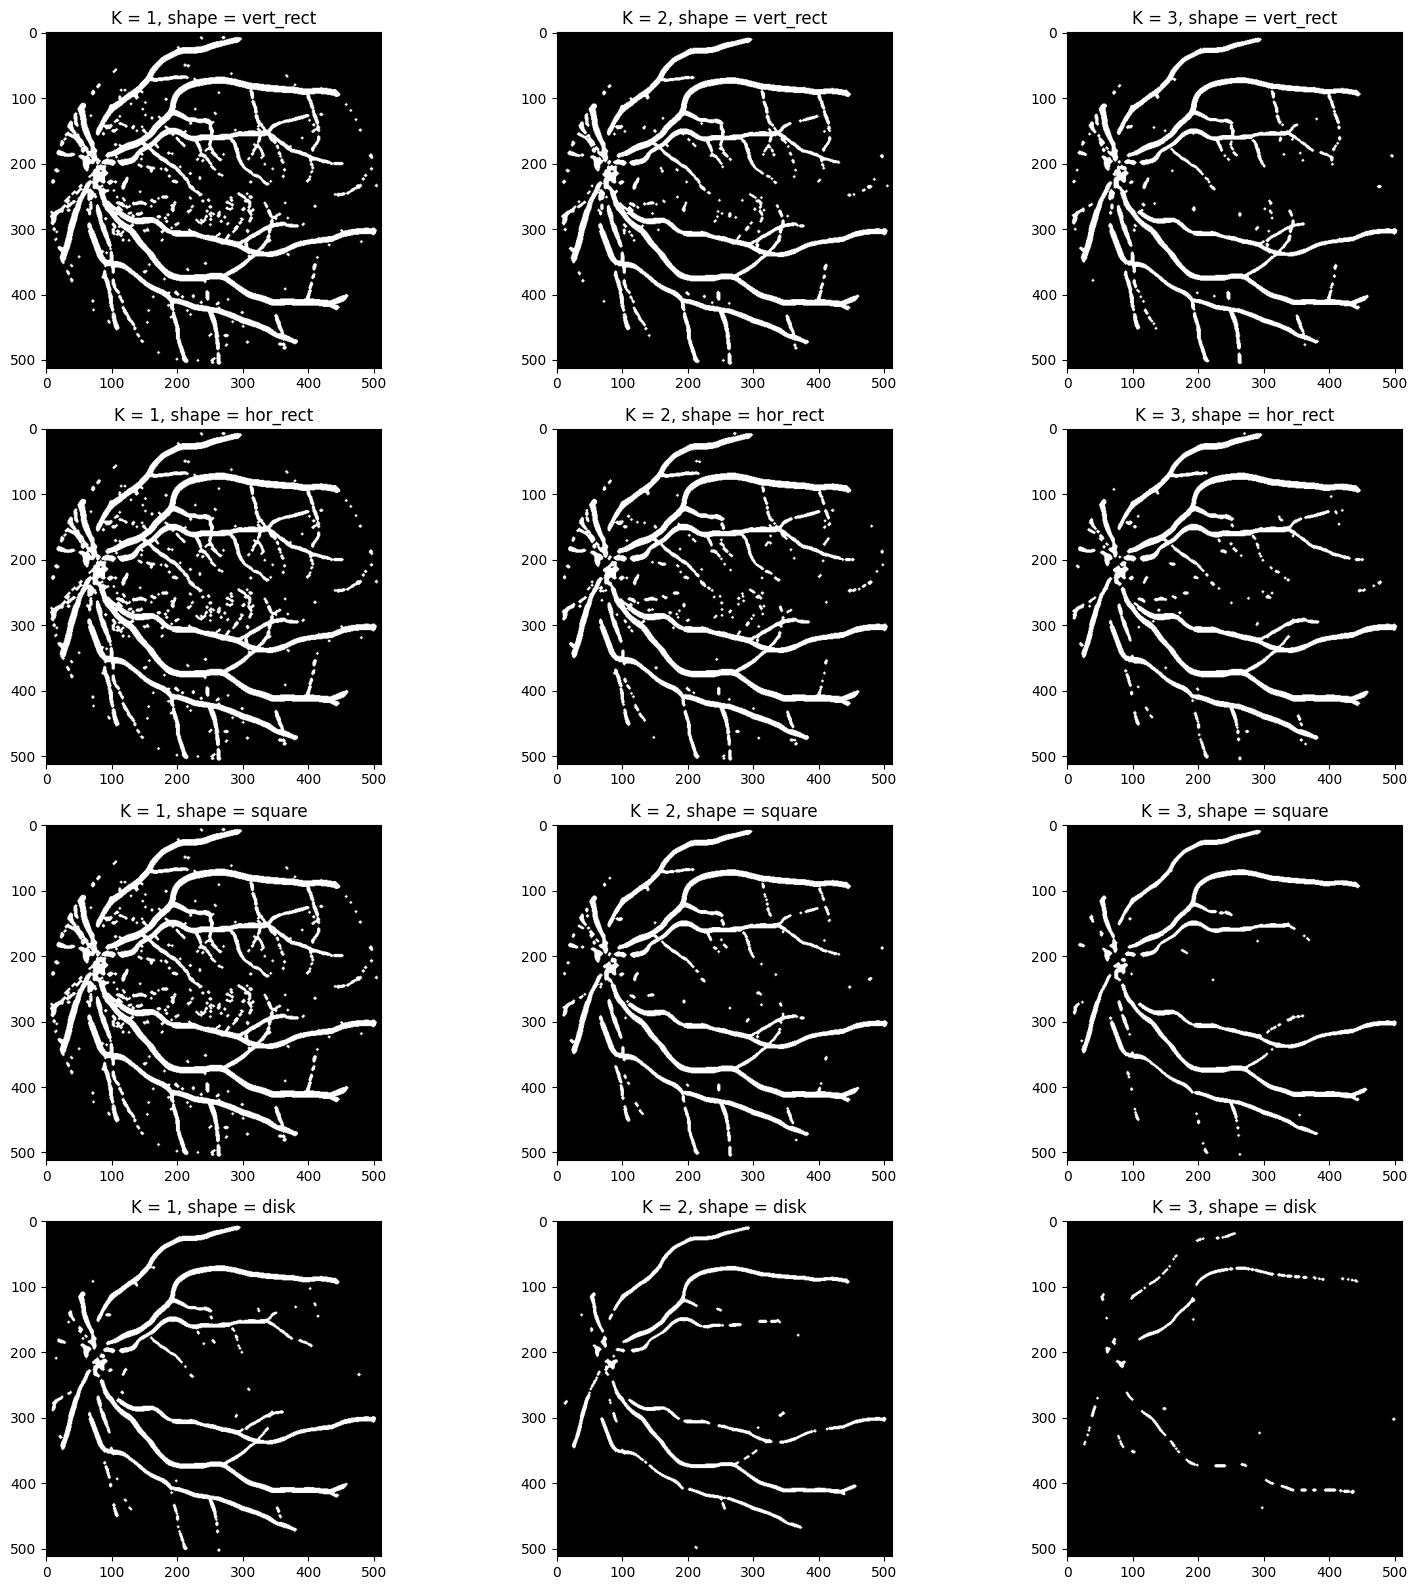

In [238]:
plt.figure(figsize=(16, 16))

test_erosion_sizes = [1,2,3]
test_erosion_shapes = ["vert_rect", "hor_rect", "square", "disk"]
accuracies = np.zeros((len(test_erosion_shapes),len(test_erosion_sizes)))
recalls = np.zeros((len(test_erosion_shapes),len(test_erosion_sizes)))

i = 0
for erosion_shape in test_erosion_shapes:
    j = 0
    for erosion_size in test_erosion_sizes:
        img_out = my_segmentation(img, img_mask, erosion_value=erosion_size, erosion_shape=erosion_shape)
        img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

        ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
        print('K = ', erosion_size, ', Shape =', erosion_shape, ', Accuracy =', ACCU,', Recall =', RECALL, ', Average = ', (ACCU + RECALL) / 2)
        accuracies[i][j] = ACCU
        recalls[i][j] = RECALL

        plt.subplot(len(test_erosion_shapes), len(test_erosion_sizes), i * len(test_erosion_sizes) + j + 1)
        plt.imshow(img_out,cmap = 'gray')
        plt.title('K = ' + str(erosion_size) + ', shape = ' + erosion_shape)
        j = j + 1
    i = i + 1

plt.tight_layout()
plt.show()

## Dilation

K =  1 , Shape = vert_rect , Accuracy = 0.9069942341438957 , Recall = 0.6285615010423905 , Average =  0.767777867593143
K =  2 , Shape = vert_rect , Accuracy = 0.8985333012743448 , Recall = 0.6730907780979827 , Average =  0.7858120396861638
K =  3 , Shape = vert_rect , Accuracy = 0.8796488796488796 , Recall = 0.6918604651162791 , Average =  0.7857546723825793
K =  1 , Shape = hor_rect , Accuracy = 0.9069942341438957 , Recall = 0.6285615010423905 , Average =  0.767777867593143
K =  2 , Shape = hor_rect , Accuracy = 0.8739578224619912 , Recall = 0.6380236305048335 , Average =  0.7559907264834123
K =  3 , Shape = hor_rect , Accuracy = 0.8757909538317319 , Recall = 0.6861917003305178 , Average =  0.7809913270811248
K =  1 , Shape = square , Accuracy = 0.9069942341438957 , Recall = 0.6285615010423905 , Average =  0.767777867593143
K =  2 , Shape = square , Accuracy = 0.8827100534239922 , Recall = 0.6823728177210437 , Average =  0.782541435572518
K =  3 , Shape = square , Accuracy = 0.889357

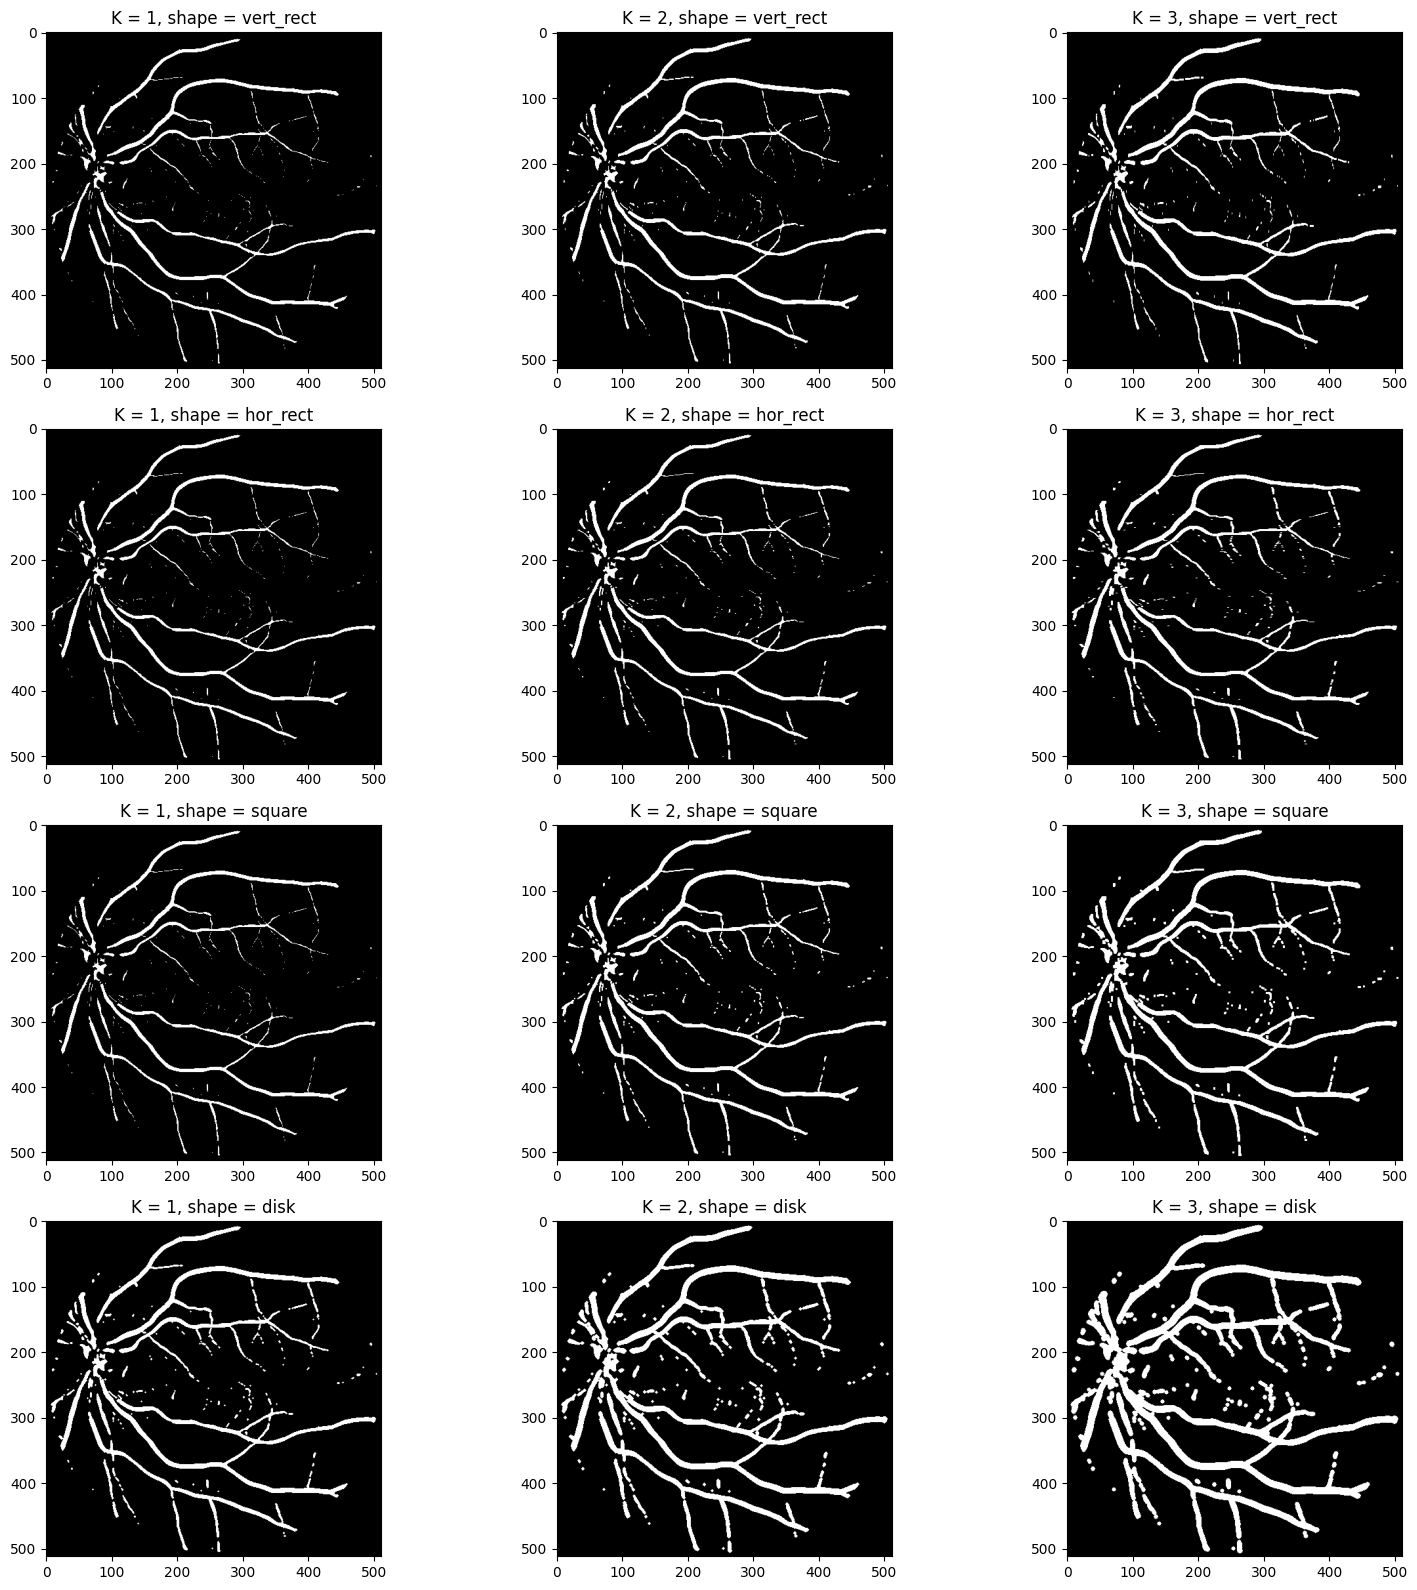

In [239]:
plt.figure(figsize=(16, 16))

test_dilation_sizes = [1,2,3]
test_dilation_shapes = ["vert_rect", "hor_rect", "square", "disk"]
accuracies = np.zeros((len(test_dilation_shapes),len(test_dilation_sizes)))
recalls = np.zeros((len(test_dilation_shapes),len(test_dilation_sizes)))

i = 0
for dilation_shape in test_dilation_shapes:
    j = 0
    for dilation_size in test_dilation_sizes:
        img_out = my_segmentation(img, img_mask, dilation_shape=dilation_shape, dilation_value=dilation_size)
        img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

        ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
        print('K = ', dilation_size, ', Shape =', dilation_shape, ', Accuracy =', ACCU,', Recall =', RECALL, ', Average = ', (ACCU + RECALL) / 2)
        accuracies[i][j] = ACCU
        recalls[i][j] = RECALL

        plt.subplot(len(test_dilation_shapes), len(test_dilation_sizes), i * len(test_dilation_sizes) + j + 1)
        plt.imshow(img_out,cmap = 'gray')
        plt.title('K = ' + str(dilation_size) + ', shape = ' + dilation_shape)
        j = j + 1
    i = i + 1

plt.tight_layout()
plt.show()

## Closing

K =  1 , Shape = vert_rect , Accuracy = 0.9043394869335891 , Recall = 0.754249150169966 , Average =  0.8292943185517776
K =  2 , Shape = vert_rect , Accuracy = 0.905870936438622 , Recall = 0.7541910725106039 , Average =  0.830031004474613
K =  3 , Shape = vert_rect , Accuracy = 0.8946492271105826 , Recall = 0.7589267702239257 , Average =  0.8267879986672542
K =  1 , Shape = hor_rect , Accuracy = 0.9043394869335891 , Recall = 0.754249150169966 , Average =  0.8292943185517776
K =  2 , Shape = hor_rect , Accuracy = 0.9092673459485686 , Recall = 0.7544283413848631 , Average =  0.8318478436667158
K =  3 , Shape = hor_rect , Accuracy = 0.9057918769526556 , Recall = 0.7580450522928399 , Average =  0.8319184646227478
K =  1 , Shape = square , Accuracy = 0.9043394869335891 , Recall = 0.754249150169966 , Average =  0.8292943185517776
K =  2 , Shape = square , Accuracy = 0.9033341328855841 , Recall = 0.7580515297906603 , Average =  0.8306928313381221
K =  3 , Shape = square , Accuracy = 0.8943378

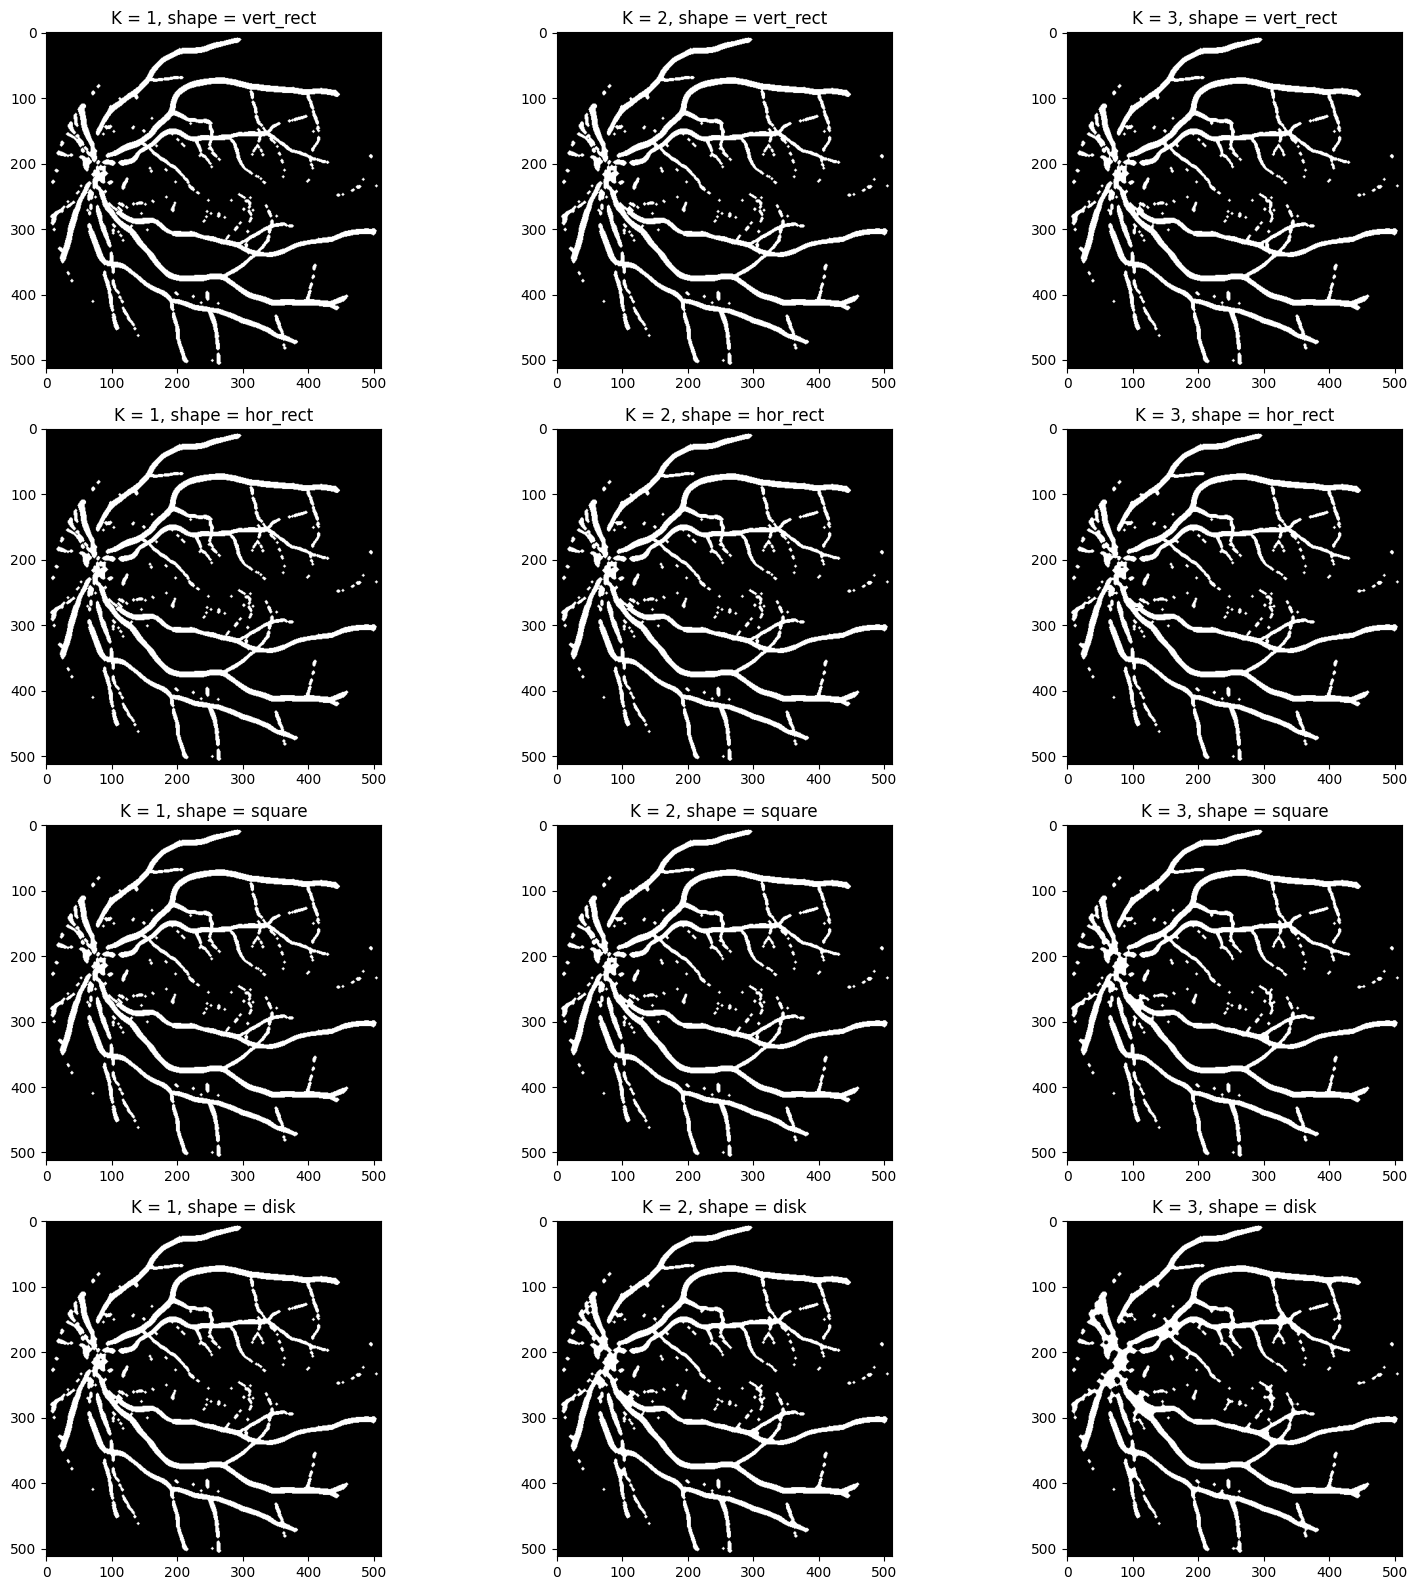

In [240]:
plt.figure(figsize=(16, 16))

test_closing_sizes = [1,2,3]
test_closing_shapes = ["vert_rect", "hor_rect", "square", "disk"]
accuracies = np.zeros((len(test_closing_shapes),len(test_closing_sizes)))
recalls = np.zeros((len(test_closing_shapes),len(test_closing_sizes)))

i = 0
for closing_shape in test_closing_shapes:
    j = 0
    for closing_size in test_closing_sizes:
        img_out = my_segmentation(img, img_mask, closing_shape=closing_shape, closing_value=closing_size)
        img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

        ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out.astype(np.int8), img_GT.astype(np.int8))
        print('K = ', closing_size, ', Shape =', closing_shape, ', Accuracy =', ACCU,', Recall =', RECALL, ', Average = ', (ACCU + RECALL) / 2)
        accuracies[i][j] = ACCU
        recalls[i][j] = RECALL

        plt.subplot(len(test_closing_shapes), len(test_closing_sizes), i * len(test_closing_sizes) + j + 1)
        plt.imshow(img_out,cmap = 'gray')
        plt.title('K = ' + str(closing_size) + ', shape = ' + closing_shape)
        j = j + 1
    i = i + 1

plt.tight_layout()
plt.show()

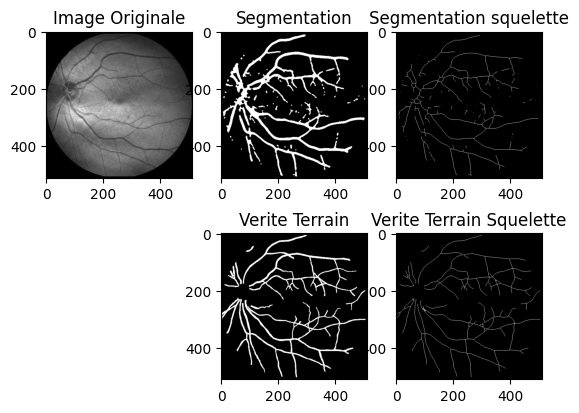

In [242]:
plt.subplot(231)
plt.imshow(img,cmap = 'gray')
plt.title('Image Originale')
plt.subplot(232)
plt.imshow(img_out, cmap='grey')
plt.title('Segmentation')
plt.subplot(233)
plt.imshow(img_out_skel, cmap='gray')
plt.title('Segmentation squelette')
plt.subplot(235)
plt.imshow(img_GT, cmap='gray')
plt.title('Verite Terrain')
plt.subplot(236)
plt.imshow(GT_skel, cmap='gray')
plt.title('Verite Terrain Squelette')
plt.show()

# References

[1] Odstrcilik, J., Kolar, R., Budai, A., Hornegger, J., Jan, J., Gazarek, J., Kubena, T., Cernosek, P., Svoboda, O., & Angelopoulou, E. (2013). Retinal vessel segmentation by improved matched filtering: evaluation on a new high‐resolution fundus image database. In IET Image Processing (Vol. 7, Issue 4, pp. 373–383). Institution of Engineering and Technology (IET). https://doi.org/10.1049/iet-ipr.2012.0455

[2] Lyu, X., Cheng, L., & Zhang, S. (2022). The RETA Benchmark for Retinal Vascular Tree Analysis. In Scientific Data (Vol. 9, Issue 1). Springer Science and Business Media LLC. https://doi.org/10.1038/s41597-022-01507-y
